<a href="https://colab.research.google.com/github/wootaehyeon/AI_lab/blob/main/AI_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt
#받아쓰기 음성인식
#랜덤한 음성파일 인식 과제
#잡음 제거 feature extraction

2.8.0+cu126
2.8.0+cu126


In [37]:
#from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    im = ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    #add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('power(dB)', rotation=270,labelpad=15)


def plot_fbank(fbank, title=None):

    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

/tmp/ipython-input-2221082486.py:7: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


In [38]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

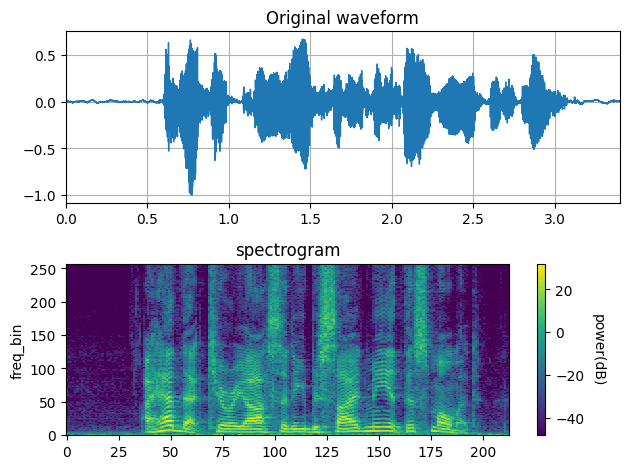

In [39]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [40]:
from IPython.display import Audio

# 오디오 재생
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)


In [41]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)

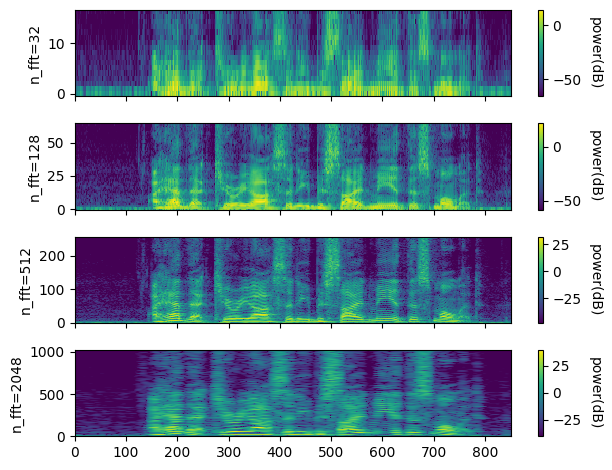

In [42]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

In [43]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [44]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

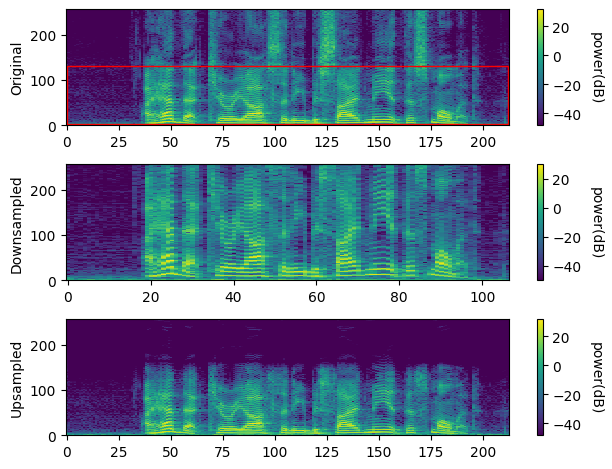

In [45]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

In [46]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffin_lim(spec)

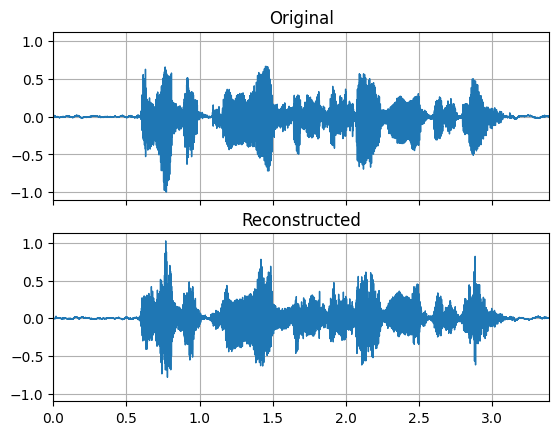

In [47]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

In [48]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

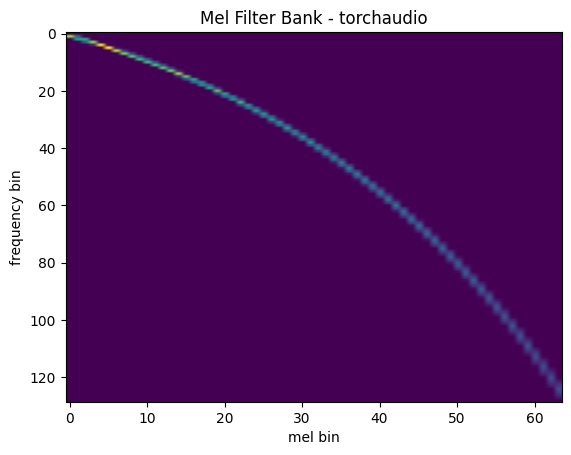

In [49]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

In [50]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

/tmp/ipython-input-607204609.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(mel_filters - mel_filters_librosa).mean().item()


Mean Square Difference:  3.934872696751886e-17


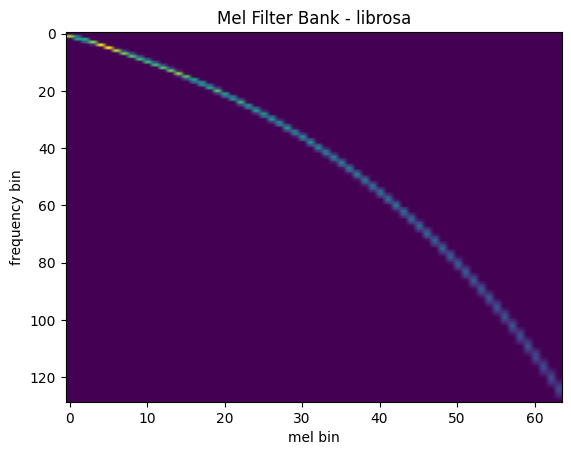

In [51]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

In [52]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

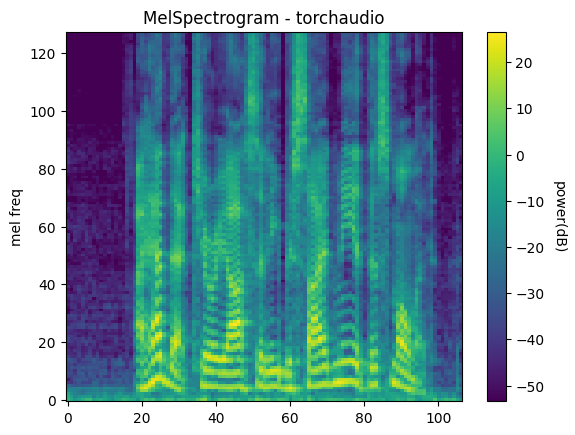

In [53]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [54]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

/tmp/ipython-input-2206006589.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(melspec - melspec_librosa).mean().item()


Mean Square Difference:  1.2880109201418577e-09


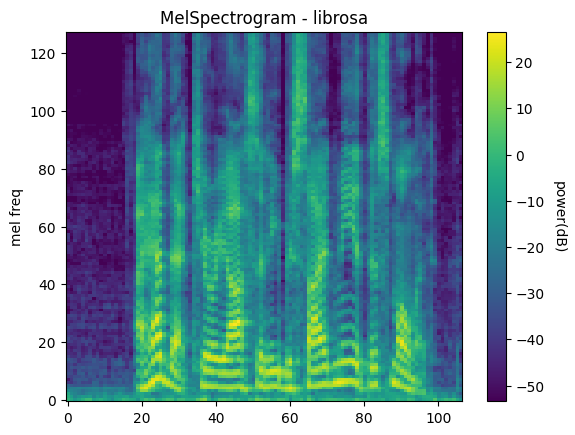

In [55]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

In [56]:
n_fft = 2048
win_length = None
hop_length = 512

n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

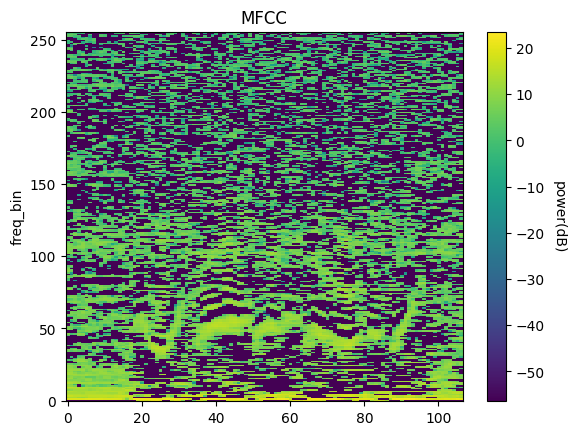

In [57]:
plot_spectrogram(mfcc[0], title="MFCC")

In [58]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

Mean Square Difference:  0.8103960752487183


/tmp/ipython-input-1658487374.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(mfcc - mfcc_librosa).mean().item()


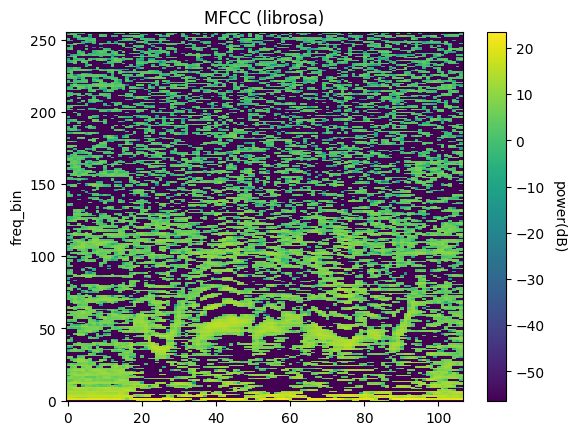

In [59]:
plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

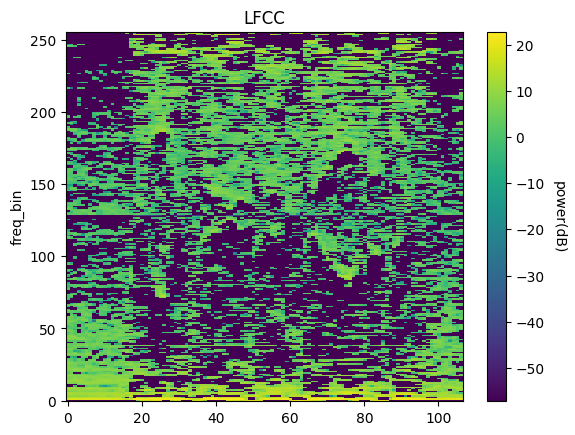

In [60]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0], title="LFCC")

In [61]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

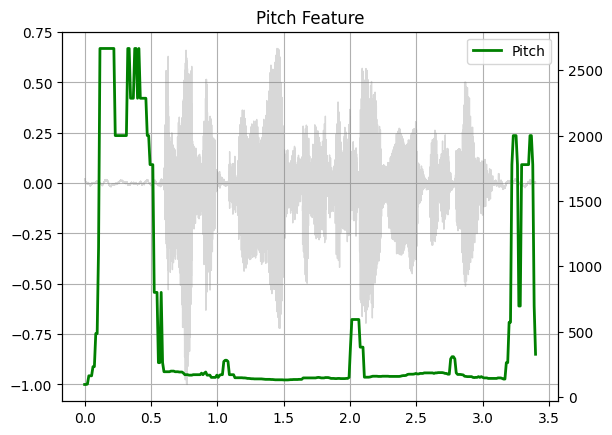

In [62]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

In [63]:
from google.colab import files
uploaded = files.upload()

Saving p_1067599_644.mp3 to p_1067599_644.mp3


In [64]:
import os
print(os.listdir())  # 현재 작업 디렉토리의 파일 리스트 확인


['LICENSE-FLAC.txt', 'make-release.sh', 'LICENSE.txt', 'setup.cfg', 'third-party', 'examples', 'reference', '.git', 'README.rst', '.gitignore', 'SpeechRecognition.egg-info', 'Makefile', 'speech_recognition', '.github', 'converted_audio.wav', 'MANIFEST.in', 'tests', 'p_1067599_644.mp3', 'setup.py']


In [66]:
from pydub import AudioSegment
import torchaudio
import speech_recognition as sr
import librosa
from pydub import AudioSegment

# MP3 파일을 WAV로 변환
audio = AudioSegment.from_mp3('p_1067599_644.mp3')
audio.export('converted_audio.wav', format='wav')  # WAV 파일로 저장



<_io.BufferedRandom name='converted_audio.wav'>

In [67]:
!pip install pydub

In [68]:
import speech_recognition as sr

# 음성 인식 준비
recognizer = sr.Recognizer()

# WAV 파일을 열어서 음성 인식 수행
with sr.AudioFile('converted_audio.wav') as source:
    audio_data = recognizer.record(source)
    text = recognizer.recognize_google(audio_data, language="en")  # 영어로 인식
    print("Recognized Text: ", text)


Recognized Text:  outside allows you to synthesize natural sounding speech several dozen voices and languages are available


In [69]:
import librosa

# 파일을 로드하여 잡음 제거 (Pre-emphasis)
y, sr = librosa.load('converted_audio.wav', sr=None)
y_denoised = librosa.effects.preemphasis(y)  # 간단한 잡음 제거

# WAV 파일의 MFCC (Mel-Frequency Cepstral Coefficients) 추출
mfcc = librosa.feature.mfcc(y=y_denoised, sr=sr)
print("MFCC Features:", mfcc)

MFCC Features: [[-8.59928040e+02 -8.59928040e+02 -8.59838196e+02 ... -7.25761536e+02
  -7.54122986e+02 -8.02318909e+02]
 [ 0.00000000e+00  0.00000000e+00 -1.01123556e-01 ...  4.22366714e+01
   3.10423279e+01  1.04621525e+01]
 [ 0.00000000e+00  0.00000000e+00  3.38894986e-02 ... -1.12348378e-01
   4.44277954e+00  7.20501041e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00 -7.79156014e-03 ...  5.50696993e+00
   3.02131987e+00 -1.73749542e+00]
 [ 0.00000000e+00  0.00000000e+00  8.29947740e-02 ...  7.86911726e+00
   4.44131088e+00 -8.43222320e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.24310456e-01 ... -4.52749205e+00
  -4.16378689e+00 -4.62197828e+00]]


# Task
Install the `speech_recognition` library from source in the Colab environment.

## Find the source code repository

### Subtask:
Locate the official source code repository for the `speech_recognition` library.


## Clone the repository

### Subtask:
Clone the `speech_recognition` source code repository from GitHub into the Colab environment.


**Reasoning**:
Clone the speech_recognition source code repository from GitHub into the Colab environment using a shell command.



In [ ]:
!git clone https://github.com/Uberi/speech_recognition.git

## Navigate to the repository directory

### Subtask:
Change the current working directory in the notebook to the cloned `speech_recognition` repository's root directory.


**Reasoning**:
Change the current working directory to the cloned `speech_recognition` directory.



In [ ]:
%cd speech_recognition

## Install from source

### Subtask:
Install the `speech_recognition` library from the source code in the current directory.


**Reasoning**:
Install the library in editable mode using pip and the current directory.



In [ ]:
!pip install -e .

## Verify installation

### Subtask:
Import the `speech_recognition` library in a Python cell to confirm that it was installed successfully.


**Reasoning**:
Import the speech_recognition library to confirm successful installation.



In [ ]:
import speech_recognition as sr
print("speech_recognition imported successfully!")

## Continue with the original task

### Subtask:
Continue with the original task of converting the audio file and performing speech recognition. This involves executing the cell that previously failed due to the missing `speech_recognition` library.


**Reasoning**:
The previous cell failed because the `speech_recognition` library was not installed. Now that it has been installed from source, I will re-run the cell to convert the audio file and proceed with the speech recognition initialization.



In [ ]:
from pydub import AudioSegment
import torchaudio
import speech_recognition as sr
import librosa

# MP3 파일을 WAV로 변환
audio = AudioSegment.from_mp3("p_1067599_644.mp3")
audio.export("converted_audio.wav", format="wav")


**Reasoning**:
The previous cell failed because the file 'p_1067599_644.mp3' was not found in the current directory. The file was uploaded to '/content/'. I need to provide the correct path to the file.



In [ ]:
from pydub import AudioSegment
import torchaudio
import speech_recognition as sr
import librosa

# MP3 파일을 WAV로 변환
audio = AudioSegment.from_mp3("/content/p_1067599_644.mp3")
audio.export("converted_audio.wav", format="wav")

**Reasoning**:
The previous step successfully converted the MP3 to WAV. Now I need to perform speech recognition on the converted WAV file. I will use the `speech_recognition` library to load the audio and recognize the speech.



In [ ]:
# Initialize the recognizer
r = sr.Recognizer()

# Load the converted audio file
with sr.AudioFile("converted_audio.wav") as source:
    audio_data = r.record(source)  # read the entire audio file

# Recognize speech using Google Web Speech API
try:
    text = r.recognize_google(audio_data)
    print("Transcription: " + text)
except sr.UnknownValueError:
    print("Google Web Speech API could not understand audio")
except sr.RequestError as e:
    print(f"Could not request results from Google Web Speech API service; {e}")


**Reasoning**:
The previous cell failed because the `speech_recognition` library requires the `flac` executable, which was not found. I need to install the `flac` package in the Colab environment.



In [ ]:
!apt update
!apt install flac

**Reasoning**:
I have installed the `flac` executable. Now I need to re-run the cell that performs speech recognition, which previously failed due to the missing `flac` executable.



In [ ]:
# Initialize the recognizer
r = sr.Recognizer()

# Load the converted audio file
with sr.AudioFile("converted_audio.wav") as source:
    audio_data = r.record(source)  # read the entire audio file

# Recognize speech using Google Web Speech API
try:
    text = r.recognize_google(audio_data)
    print("Transcription: " + text)
except sr.UnknownValueError:
    print("Google Web Speech API could not understand audio")
except sr.RequestError as e:
    print(f"Could not request results from Google Web Speech API service; {e}")


In [ ]:

# 예시: WAV 파일을 불러오기
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load("converted_audio.wav")

# 스펙트로그램 계산
spec = T.MelSpectrogram()(SPEECH_WAVEFORM)

# 파형과 스펙트로그램을 그리는 함수
def plot_waveform(waveform, sample_rate, title="Waveform", ax=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_title(title)

def plot_spectrogram(spec, title="Spectrogram", ax=None):
    ax.imshow(spec.log2(), aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# 서브 플롯 생성
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# 파형과 스펙트로그램 그리기
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="Spectrogram", ax=axs[1])

# 레이아웃 조정
fig.tight_layout()

# 그래프 출력
plt.show()


## Summary:

### Data Analysis Key Findings

*   The `speech_recognition` library was successfully installed from its source code repository cloned from GitHub.
*   The installation was performed in editable mode using `pip install -e .`.
*   The installation process involved uninstalling a previous version of the library before installing from the local source.
*   Verification confirmed that the `speech_recognition` library could be successfully imported.
*   The speech recognition process required the installation of the `flac` executable, which was missing initially.
*   After installing `flac`, the speech recognition on the converted WAV file using the Google Web Speech API was successful.

### Insights or Next Steps

*   Installing libraries from source can be necessary when the latest features or specific versions are required, or when troubleshooting installation issues from standard package managers.
*   Dependencies for libraries like `speech_recognition` might extend beyond Python packages to include system-level executables (like `flac`), which need to be installed separately.
